In [2]:
%config Completer.use_jedi = False

import os
import pandas as pd
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem, rdFMCS, DataStructs, Draw
import umap
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../data/ChEMBL_activities_for_bindingMOAD_2024.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596830 entries, 0 to 596829
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   accession           596830 non-null  object 
 1   molecule_chembl_id  596830 non-null  object 
 2   standard_type       596830 non-null  object 
 3   standard_relation   596830 non-null  object 
 4   standard_value      596830 non-null  float64
 5   standard_units      596830 non-null  object 
 6   standard_inchi_key  596830 non-null  object 
 7   canonical_smiles    596830 non-null  object 
 8   target_chembl_id    596830 non-null  object 
 9   assay_chembl_id     596830 non-null  object 
 10  variant_id          18417 non-null   float64
 11  chirality           596830 non-null  float64
 12  activity_id         596830 non-null  float64
 13  pchembl_value       596830 non-null  float64
dtypes: float64(5), object(9)
memory usage: 63.7+ MB


In [4]:
len(df.accession.unique())

774

In [5]:
len(df.drop_duplicates(subset=['accession', 'molecule_chembl_id']))

464258

In [6]:
df = pd.read_csv('../data/BindingDB_activities_for_BindingMOAD_2024.csv')
# df = info()

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
len(df['UniProt (SwissProt) Primary ID of Target Chain'].unique())

In [ ]:
len(df.drop_duplicates(subset=['BindingDB MonomerID', 'UniProt (SwissProt) Primary ID of Target Chain']))

# Ligands to dock

In [7]:
che_to_dock = pd.read_csv('../data/ChEMBL_ligands_selected_for_docking.csv')
bdb_to_dock = pd.read_csv('../data/BindingDB_ligands_selected_for_docking.csv')

In [8]:
che_to_dock = che_to_dock.rename(columns={'ChEMBL_ID': 'Docked',
                                          'ChEMBL_Smiles': 'Docked_Smiles'
                                         })
bdb_to_dock = bdb_to_dock.rename(columns={'BindingDB_ID': 'Docked',
                                          'BindingDB_Smiles': 'Docked_Smiles'
                                         })
bdb_to_dock['Docked'] = 'BINDINGDB' + bdb_to_dock.Docked.astype(str)

In [9]:
print(len(che_to_dock.drop_duplicates(subset=['UniProt_ID', 'Docked'])))
print(len(che_to_dock.drop_duplicates(subset=['UniProt_ID'])))


28677
649


In [10]:
print(len(bdb_to_dock.drop_duplicates(subset=['UniProt_ID', 'Docked'])))
print(len(bdb_to_dock.drop_duplicates(subset=['UniProt_ID'])))

36044
540


In [11]:
combined_to_dock = pd.concat([che_to_dock, bdb_to_dock])
combined_to_dock

,UniProt_ID,BM_Template,BM_Smiles,Docked,Docked_Smiles,Tanimoto_Similarity
0,A4TVL0,6R11_JOB,c1cc2c(cc1N)C(=O)N(C2=O)[C@H]3CC(=O)NC3=O,CHEMBL4455877,Nc1ccc2c(c1)C(=O)N(C1CC(=O)NC1=O)C2=O,1.00
1,A4TVL0,6R1D_JP5,c1ccc(cc1)COC(=O)N[C@H]2CC(=O)NC2=O,CHEMBL4464143,O=C1CC(NC(=O)OCc2ccccc2)C(=O)N1,1.00
2,A4TVL0,6R1D_JP5,c1ccc(cc1)COC(=O)N[C@H]2CC(=O)NC2=O,CHEMBL4556836,NCc1ccc(COC(=O)NC2CC(=O)NC2=O)cc1,0.77
3,A4TVL0,6R1K_JPB,c1c(cc(c(c1Cl)C(=O)N[C@H]2CC(=O)NC2=O)Cl)Cl,CHEMBL4437349,O=C1CC(NC(=O)c2c(Cl)cc(Cl)cc2Cl)C(=O)N1,1.00
4,A5H660,4BZ6_SHH,c1ccc(cc1)NC(=O)CCCCCCC(=O)NO,CHEMBL98,O=C(CCCCCCC(=O)Nc1ccccc1)NO,1.00
...,...,...,...,...,...,...
64521,Q9Y6F1,4L7R_M00,CC[C@@H](CO)NC(=O)CCC1=Nc2ccccc2C(=O)N1,BINDINGDB50444029,CC[C@@H](CO)NC(=O)CCc1nc2ccccc2c(=O)[nH]1,1.00
64522,Q9Y6F1,4L7R_M00,CC[C@@H](CO)NC(=O)CCC1=Nc2ccccc2C(=O)N1,BINDINGDB50444030,C[C@@H](CO)NC(=O)CCc1nc2ccccc2c(=O)[nH]1,0.93
64523,Q9Y6F1,4L7R_M00,CC[C@@H](CO)NC(=O)CCC1=Nc2ccccc2C(=O)N1,BINDINGDB50444033,OC[C@H](Cc1ccccc1)NC(=O)CCc1nc2ccccc2c(=O)[nH]1,0.82
64524,Q9ZLT0,2JFZ_003,CC(C)CN1c2c(c(n(n2)Cc3cccc4c3cccc4)c5ccncc5)C(...,BINDINGDB50421085,CC(C)Cn1c2nn(Cc3cccc4ccccc34)c(-c3cncn3C)c2c(=...,0.75


In [12]:
unique_to_dock = combined_to_dock.drop_duplicates(subset=['UniProt_ID', 'Docked'])
temp_lig = combined_to_dock.drop_duplicates(subset=['BM_Template', 'Docked'])

/tmp/ipykernel_187175/2948389904.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_counts = (pair_counts_combined.groupby(['Bin', 'Source']).size().unstack(fill_value=0)


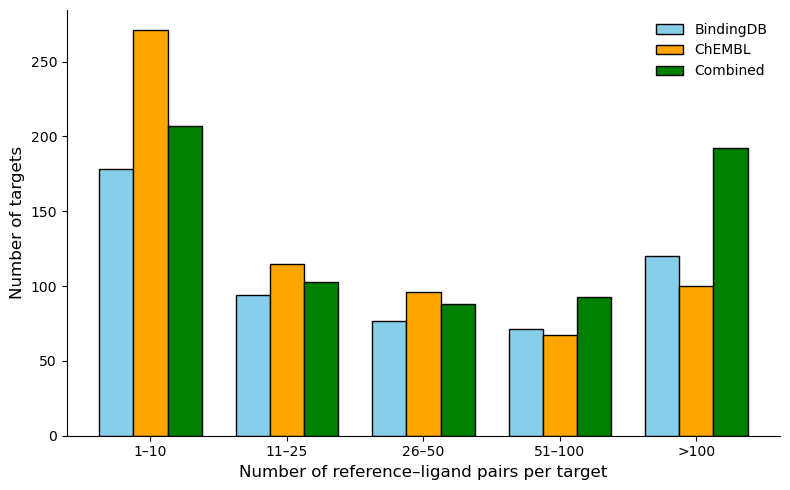

In [28]:
combined_to_dock['Source'] = combined_to_dock['Docked'].str.extract(r'^(CHEMBL|BINDINGDB)')

# Count per UniProt_ID and source
pair_counts = (combined_to_dock.groupby(['UniProt_ID', 'Source']).size().reset_index(name='Count'))

# Count per UniProt_ID across all sources (total)
total_counts = (combined_to_dock.groupby(['UniProt_ID']).size().reset_index(name='Count'))
total_counts['Source'] = 'Total'

pair_counts_combined = pd.concat([pair_counts, total_counts], ignore_index=True)

bins = [0, 10, 25, 50, 100, float('inf')]
labels = ['1–10', '11–25', '26–50', '51–100', '>100']

pair_counts_combined['Bin'] = pd.cut(pair_counts_combined['Count'], bins=bins, labels=labels, right=True)

binned_counts = (pair_counts_combined.groupby(['Bin', 'Source']).size().unstack(fill_value=0)
                 .reindex(columns=['BINDINGDB', 'CHEMBL', 'Total']))

x = np.arange(len(labels))
width = 0.25
sources = ['BINDINGDB', 'CHEMBL', 'Total']
colors = {'BINDINGDB': 'skyblue', 'CHEMBL': 'orange', 'Total': 'green'}

fig, ax = plt.subplots(figsize=(8, 5))
for i, source in enumerate(sources):
    offset = (i - 1) * width
    ax.bar(x + offset, binned_counts[source], width, label=source, edgecolor='black', color=colors[source])

ax.set_xlabel('Number of reference–ligand pairs per target', fontsize=12)
ax.set_ylabel('Number of targets', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(labels)

custom_labels = {'BINDINGDB': 'BindingDB',
                 'CHEMBL': 'ChEMBL',
                 'Total': 'Combined'}

handles, labels_ = ax.get_legend_handles_labels()
new_labels = [custom_labels.get(label, label) for label in labels_]
ax.legend(handles=handles, labels=new_labels,frameon=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('../images/ligands_per_target_selected_for_docking.png', dpi=300, bbox_inches='tight')
plt.show()


In [65]:
combined_to_dock

,UniProt_ID,BM_Template,BM_Smiles,Docked,Docked_Smiles,Tanimoto_Similarity,Source
0,A4TVL0,6R11_JOB,c1cc2c(cc1N)C(=O)N(C2=O)[C@H]3CC(=O)NC3=O,CHEMBL4455877,Nc1ccc2c(c1)C(=O)N(C1CC(=O)NC1=O)C2=O,1.00,CHEMBL
1,A4TVL0,6R1D_JP5,c1ccc(cc1)COC(=O)N[C@H]2CC(=O)NC2=O,CHEMBL4464143,O=C1CC(NC(=O)OCc2ccccc2)C(=O)N1,1.00,CHEMBL
2,A4TVL0,6R1D_JP5,c1ccc(cc1)COC(=O)N[C@H]2CC(=O)NC2=O,CHEMBL4556836,NCc1ccc(COC(=O)NC2CC(=O)NC2=O)cc1,0.77,CHEMBL
3,A4TVL0,6R1K_JPB,c1c(cc(c(c1Cl)C(=O)N[C@H]2CC(=O)NC2=O)Cl)Cl,CHEMBL4437349,O=C1CC(NC(=O)c2c(Cl)cc(Cl)cc2Cl)C(=O)N1,1.00,CHEMBL
4,A5H660,4BZ6_SHH,c1ccc(cc1)NC(=O)CCCCCCC(=O)NO,CHEMBL98,O=C(CCCCCCC(=O)Nc1ccccc1)NO,1.00,CHEMBL
...,...,...,...,...,...,...,...
64521,Q9Y6F1,4L7R_M00,CC[C@@H](CO)NC(=O)CCC1=Nc2ccccc2C(=O)N1,BINDINGDB50444029,CC[C@@H](CO)NC(=O)CCc1nc2ccccc2c(=O)[nH]1,1.00,BINDINGDB
64522,Q9Y6F1,4L7R_M00,CC[C@@H](CO)NC(=O)CCC1=Nc2ccccc2C(=O)N1,BINDINGDB50444030,C[C@@H](CO)NC(=O)CCc1nc2ccccc2c(=O)[nH]1,0.93,BINDINGDB
64523,Q9Y6F1,4L7R_M00,CC[C@@H](CO)NC(=O)CCC1=Nc2ccccc2C(=O)N1,BINDINGDB50444033,OC[C@H](Cc1ccccc1)NC(=O)CCc1nc2ccccc2c(=O)[nH]1,0.82,BINDINGDB
64524,Q9ZLT0,2JFZ_003,CC(C)CN1c2c(c(n(n2)Cc3cccc4c3cccc4)c5ccncc5)C(...,BINDINGDB50421085,CC(C)Cn1c2nn(Cc3cccc4ccccc34)c(-c3cncn3C)c2c(=...,0.75,BINDINGDB


In [38]:
print(f'Target-ligand pairs: {len(unique_to_dock)}')
print(f'Reference-ligand pairs: {len(temp_lig)}')

print(f'Unique ligands: {len(unique_to_dock.Docked.unique())}')
print(f'Unique templates: {len(unique_to_dock.BM_Template.unique())}')
print(f'Unique targets: {len(unique_to_dock.UniProt_ID.unique())}')


Target-ligand pairs: 64721
Reference-ligand pairs: 108559
Unique ligands: 61621
Unique ligands: 6518
Unique targets: 683
